In [2]:
#Reference1: https://keras.io/examples/nlp/lstm_seq2seq/
#Reference2: https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/ 

In [1]:
#get the tar file from the location
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

--2021-04-25 16:54:32--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.208, 172.253.62.128, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  24.3MB/s    in 18s     

2021-04-25 16:54:49 (107 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [2]:
#extract it
!tar -xvf 'dakshina_dataset_v1.0.tar'

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.nonblock.sections.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.omit_pages.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/na

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random
from keras.utils.vis_utils import plot_model


In [18]:
batch_size = 64  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space. #hidden states hyperparameter
#num_samples = 25000  # Number of samples to train on.
# Path to the data txt file on disk.
train_hindi = "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_hindi="/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
train_marathi="/content/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv"
val_marathi="/content/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv"
#open and save the files to lists
#using hindi and marathi since it is asked devanagiri and both are devanagiri
with open(train_hindi, "r", encoding="utf-8") as f:
    train_hindi_lines = f.read().split("\n")
with open(val_hindi, "r", encoding="utf-8") as f:
    val_hindi_lines = f.read().split("\n")
with open(train_marathi, "r", encoding="utf-8") as f:
    train_marathi_lines = f.read().split("\n")
with open(val_marathi, "r", encoding="utf-8") as f:
    val_marathi_lines = f.read().split("\n")
#popping the last element of all the lists since it is empty character
train_hindi_lines.pop()
train_marathi_lines.pop()
val_hindi_lines.pop()
val_marathi_lines.pop()
#combine the train of hindi and marathi
#uncomment to include marathi also
train_lines=train_hindi_lines+train_marathi_lines
#combine the validation of hindi and marathi 
val_lines=val_hindi_lines+val_marathi_lines
random.shuffle(train_lines)
print(train_lines[1:10])


['यजीद\tyajid\t1', 'लोकोत्सव\tlokotsav\t3', 'प्रकल्पाचा\tprakalpacha\t3', 'बौद्धिक\tbauddhik\t2', 'बैल\tbel\t1', 'जीपीएस\tgps\t3', 'कसैले\tkasaile\t2', 'ध्रुवीकरण\tdhruveekaran\t1', 'मान्सून\tmonshoon\t1']


In [19]:
#embedding pre processing
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
#go through the train lines and split them into 3 and save input and target 
for line in train_lines[: (len(train_lines) - 1)]:
    #because we want english to devanagiri conversion 
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    #append it to the main input texts list
    input_texts.append(input_text)
    #append it to the main target texts list 
    target_texts.append(target_text)
    # to find the number of unique characters in both
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
#add the space character to both 
input_characters.add(" ")
target_characters.add(" ")
#sort it
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
#find the number 
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# find the maximum length of input word and target word
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)
# create an index 
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
print((input_token_index))
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
print((target_token_index))
#create an 0 array for encoder input size of (input_texts,max_seqlen,tokens)
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
#create decoder input 
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
#create decoder target
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
#for each sample convert it into character encoding i.e. if 
#at that position a character is present then encode the index of that character there
#this is done for both encoder and decoder input data for further word embedding
#but target data is one hot encoded.
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t]=input_token_index[char]
    #remaining positions set as empty space 
    encoder_input_data[i, t + 1 :]= input_token_index[" "]
    #similarly do for decoder data 
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t]= target_token_index[char]
        #check if t >0 since decoder targer data is ahead
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1,target_token_index[char]]=1.0
    #append both the remaining positions of both the datas with empty space
    decoder_input_data[i, t + 1 :]= target_token_index[" "] 
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 100506
Number of unique input tokens: 27
Number of unique output tokens: 71
Max sequence length for inputs: 23
Max sequence length for outputs: 22
{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{'\t': 0, '\n': 1, ' ': 2, 'ँ': 3, 'ं': 4, 'ः': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऍ': 13, 'ए': 14, 'ऐ': 15, 'ऑ': 16, 'ओ': 17, 'औ': 18, 'क': 19, 'ख': 20, 'ग': 21, 'घ': 22, 'ङ': 23, 'च': 24, 'छ': 25, 'ज': 26, 'झ': 27, 'ञ': 28, 'ट': 29, 'ठ': 30, 'ड': 31, 'ढ': 32, 'ण': 33, 'त': 34, 'थ': 35, 'द': 36, 'ध': 37, 'न': 38, 'प': 39, 'फ': 40, 'ब': 41, 'भ': 42, 'म': 43, 'य': 44, 'र': 45, 'ऱ': 46, 'ल': 47, 'ळ': 48, 'व': 49, 'श': 50, 'ष': 51, 'स': 52, 'ह': 53, '़': 54, 'ा': 55, 'ि': 56, 'ी': 57, 'ु': 58, 'ू': 59, 'ृ': 60, 'ॅ': 61, 'े': 62, 'ै': 63, 'ॉ': 64, 'ो': 65, 'ौ': 66, '्':

In [20]:
#embedding validation 
#for validation data, almost same 
val_input_texts = []
val_target_texts = []
for line in val_lines[: (len(val_lines) - 1)]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    val_input_texts.append(input_text)
    val_target_texts.append(target_text)
val_max_encoder_seq_length = max([len(txt) for txt in val_input_texts])
val_max_decoder_seq_length = max([len(txt) for txt in val_target_texts])
val_encoder_input_data = np.zeros(
    (len(val_input_texts), val_max_encoder_seq_length), dtype="float32"
)
val_decoder_input_data = np.zeros(
    (len(val_input_texts), val_max_decoder_seq_length), dtype="float32"
)
val_decoder_target_data = np.zeros(
    (len(val_input_texts), val_max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
for i, (input_text, target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t]= input_token_index[char]
    val_encoder_input_data[i, t + 1 :]= input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t]= target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1,target_token_index[char]]=1.0
    val_decoder_input_data[i, t + 1 :]= target_token_index[" "]
    val_decoder_target_data[i, t:,target_token_index[" "]]=1.0


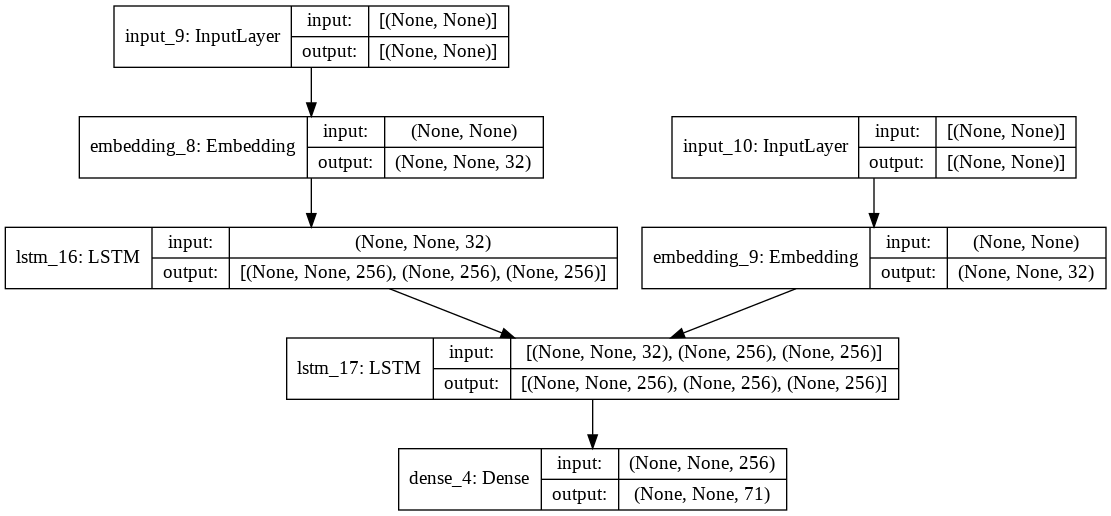

In [21]:
#input layer
encoder_inputs = keras.Input(shape=(None,))
#word embedding layer
embeden=tf.keras.layers.Embedding(input_dim=num_encoder_tokens,output_dim=32)(encoder_inputs)
encoder = keras.layers.LSTM(latent_dim, return_state=True,return_sequences=True)
encoder_outputs, state_h, state_c = encoder(embeden)
#1st layer
#number of encoder layers 
e_layer=1
for i in range(2,e_layer+1):
  encoder = keras.layers.LSTM(latent_dim, return_sequences=True,return_state=True)
  #give the output sequences as input to the next layer also the last state is set as initial state of next layer
  encoder_outputs, state_h, state_c = encoder(encoder_outputs,initial_state=[state_h,state_c])

#save the last state
encoder_states=[state_h,state_c]
decoder_inputs = keras.Input(shape=(None,))
embedde=tf.keras.layers.Embedding(num_decoder_tokens,32)(decoder_inputs)
#number of decoder layers 
d_layer=1
#first layer
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
#all decodders the initial state is encoder last state of last layer 
decoder_outputs, _, _ = decoder_lstm(embedde, initial_state=encoder_states)
for i in range(2,d_layer+1):
  decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_outputs, initial_state=encoder_states)
#add a dense layer 
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs,decoder_inputs], decoder_outputs)
#plot the model
plot_model(model, to_file='model.png', show_shapes=True)


In [22]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data,decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_encoder_input_data, val_decoder_input_data],
    val_decoder_target_data)
)


Epoch 1/20
1571/1571 [==============================] - 17s 9ms/step - loss: 1.0870 - accuracy: 0.7266 - val_loss: 0.8136 - val_accuracy: 0.7699
Epoch 2/20
1571/1571 [==============================] - 14s 9ms/step - loss: 0.6516 - accuracy: 0.8143 - val_loss: 0.6505 - val_accuracy: 0.8093
Epoch 3/20
1571/1571 [==============================] - 14s 9ms/step - loss: 0.4819 - accuracy: 0.8571 - val_loss: 0.4877 - val_accuracy: 0.8539
Epoch 4/20
1571/1571 [==============================] - 14s 9ms/step - loss: 0.3504 - accuracy: 0.8939 - val_loss: 0.3825 - val_accuracy: 0.8836
Epoch 5/20
1571/1571 [==============================] - 14s 9ms/step - loss: 0.2519 - accuracy: 0.9232 - val_loss: 0.3126 - val_accuracy: 0.9037
Epoch 6/20
1571/1571 [==============================] - 14s 9ms/step - loss: 0.1933 - accuracy: 0.9411 - val_loss: 0.2746 - val_accuracy: 0.9159
Epoch 7/20
1571/1571 [==============================] - 14s 9ms/step - loss: 0.1551 - accuracy: 0.9529 - val_loss: 0.2484 - val_ac

In [ ]:
#ununsed block below 

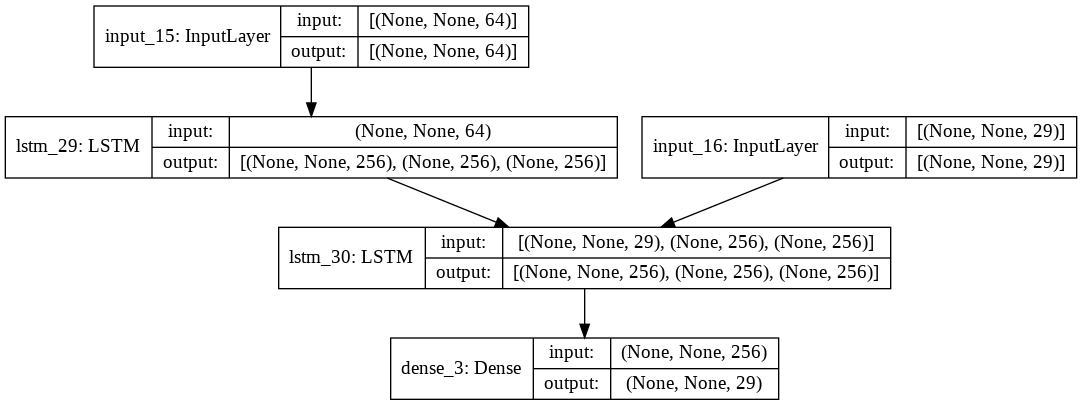

In [25]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))

encoder = keras.layers.LSTM(latent_dim, return_state=True,return_sequences=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, to_file='model.png', show_shapes=True)

In [5]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
#go through the train lines and split them into 3 and save input and target 
for line in train_lines[: (len(train_lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    #append it to the main input texts list
    input_texts.append(input_text)
    #append it to the main target texts list 
    target_texts.append(target_text)
    # to find the number of unique characters in both
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
#add the space character to both 
input_characters.add(" ")
target_characters.add(" ")
#sort it
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
#find the number 
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# find the maximum length of input word and target word
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)
# create an index 
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
#create an 0 array for encoder input size of (input_texts,max_seqlen,tokens)
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
#create decoder input 
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
#create decoder target
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
#for each sample if the alphabet is present set it to 1
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    #set space also to 1 , dont know why
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 44203
Number of unique input tokens: 64
Number of unique output tokens: 29
Max sequence length for inputs: 19
Max sequence length for outputs: 22


In [23]:
#for validation data, almost same 
val_input_texts = []
val_target_texts = []
#with open(data_path, "r", encoding="utf-8") as f:
    #lines = f.read().split("\n")
#for line in lines[: min(num_samples, len(lines) - 1)]:
for line in val_lines[: (len(val_lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    val_input_texts.append(input_text)
    val_target_texts.append(target_text)
val_max_encoder_seq_length = max([len(txt) for txt in val_input_texts])
val_max_decoder_seq_length = max([len(txt) for txt in val_target_texts])
val_encoder_input_data = np.zeros(
    (len(val_input_texts), val_max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
val_decoder_input_data = np.zeros(
    (len(val_input_texts), val_max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
val_decoder_target_data = np.zeros(
    (len(val_input_texts), val_max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
for i, (input_text, target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t, input_token_index[char]] = 1.0
    val_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    val_decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    val_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

